In [1]:
import requests
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# ==========================================
# 1) Função para baixar dados
# ==========================================
def baixar_dados(start, end, lat=-23.08720429991206, lon=-47.2100151415641):
    BASE_URL = "https://power.larc.nasa.gov/api/temporal/hourly/point"
    params = {
        "parameters": "T2M,RH2M,WS2M,ALLSKY_SFC_SW_DWN,PS,PRECTOTCORR",
        "community": "AG",
        "longitude": lon,
        "latitude": lat,
        "format": "JSON",
        "start": start,
        "end": end
    }
    response = requests.get(BASE_URL, params=params)
    if response.status_code == 200:
        data = response.json()
        parameters = data["properties"]["parameter"]
        df = pd.DataFrame(parameters)
        df.index = pd.to_datetime(df.index, format="%Y%m%d%H")
        df = df.sort_index()
        return df
    else:
        raise ValueError(f"Erro {response.status_code}: {response.text}")

# ==========================================
# 2) Preparar histórico para anos anteriores
# ==========================================
def coletar_historico_anos(data_futura_str, anos=5, janela_dias=7, lat=-23.08720429991206, lon=-47.2100151415641):
    data_futura = pd.to_datetime(data_futura_str)
    df_list = []

    for i in range(1, anos+1):
        ano = data_futura.year - i
        data_base = data_futura.replace(year=ano)
        start = (data_base - timedelta(days=janela_dias)).strftime("%Y%m%d")
        end   = (data_base + timedelta(days=janela_dias)).strftime("%Y%m%d")
        try:
            df_historico = baixar_dados(start, end, lat, lon)
            df_list.append(df_historico)
        except Exception as e:
            print(f"Erro: {ano} - {e}")

    if not df_list:
        raise ValueError(".")
    df_total = pd.concat(df_list)
    df_total = df_total.sort_index()
    return df_total

# ==========================================
# 3) Treinar modelo e prever
# ==========================================
def treinar_e_prever(df_historico, data_futura_str, target="T2M", janela=24):
    # Normaliza os dados
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df_historico), index=df_historico.index, columns=df_historico.columns)

    # Cria janelas temporais
    X, y = [], []
    for i in range(len(df_scaled) - janela):
        X.append(df_scaled.iloc[i:i+janela].values.flatten())
        y.append(df_scaled[target].iloc[i+janela])
    X = np.array(X)
    y = np.array(y)

    # Divide treino/teste (80/20)
    split = int(len(X) * 0.8)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    # Treina RandomForest
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Métricas
    preds_test = model.predict(X_test)
    target_scaler = StandardScaler()
    target_scaler.fit(df_historico[[target]])
    y_test_real = target_scaler.inverse_transform(y_test.reshape(-1,1)).flatten()
    preds_real = target_scaler.inverse_transform(preds_test.reshape(-1,1)).flatten()
    rmse = root_mean_squared_error(y_test_real, preds_real)
    mae = mean_absolute_error(y_test_real, preds_real)
    print(f"RMSE teste: {rmse:.2f}, MAE teste: {mae:.2f}")

    # Gráfico
    plt.figure(figsize=(12,5))
    plt.plot(y_test_real, label="Real")
    plt.plot(preds_real, label="Previsto")
    plt.legend()
    plt.title("Previsão - Teste")
    plt.xlabel("Hora")
    plt.ylabel("Temperatura (°C)")
    plt.show()

    # Previsão para a data futura
    ultima_janela = df_scaled.iloc[-janela:].values.flatten().reshape(1, -1)
    pred_futura_scaled = model.predict(ultima_janela)
    pred_futura_real = target_scaler.inverse_transform(pred_futura_scaled.reshape(-1,1))[0,0]
    return pred_futura_real

# ==========================================
# 4) Função principal
# ==========================================
def prever_data_futura_anos(data_futura_str, anos=5, janela_dias=7, janela_modelo=24, lat=-23.08720429991206, lon=-47.2100151415641):
    print("Coletando histórico...")
    df_hist = coletar_historico_anos(data_futura_str, anos=anos, janela_dias=janela_dias, lat=lat, lon=lon)
    print("Treinando modelo e prevendo...")
    previsao = treinar_e_prever(df_hist, data_futura_str, janela=janela_modelo)
    return previsao




Coletando histórico...
Treinando modelo e prevendo...
RMSE teste: 0.72, MAE teste: 0.51


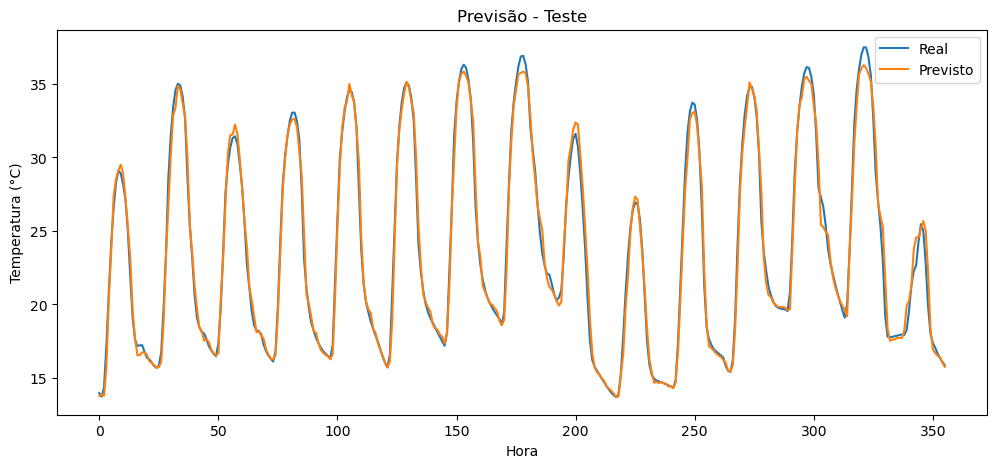

Previsão: 15.58°C


In [2]:
# ==========================================
# 5) Consultar temperatura
# ==========================================

previsao = prever_data_futura_anos(
    "2025-09-26 14:00",
    anos=5,
    janela_dias=7,
    janela_modelo=24,
    lat=-23.55,  
    lon=-46.63   
)

print(f"Previsão: {previsao:.2f}°C")